In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00


In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
with plt.ioff():
    fig, ax = plt.subplots()

In [ ]:
def generate_xor(N: int, noise: int):
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else -1

    get_xor_label = np.vectorize(get_xor_label)
    padding = .3
    x = np.random.uniform(-5, 5, N)
    x += np.where(x > 0, padding, -padding)
    y = np.random.uniform(-5, 5, N)
    y += np.where(y > 0, padding, -padding)
    noise_x = np.random.uniform(-5, 5, N) * noise
    noise_y = np.random.uniform(-5, 5, N) * noise
    labels = np.where((x + noise_x) * (y + noise_y) >= 0, 1, -1)
    # labels = get_xor_label(x + noise_x, y + noise_y)
    return x, y, labels

def generate_spiral(N: int, noise: int):
    n = N // 2

    def gen_sigle_spiral(delta_t: int, label: int):
        r = np.arange(n) / n * 5
        t = 1.75 * np.arange(n) / n * 2 * np.pi + delta_t
        x = r * np.sin(t) + np.random.uniform(-1, 1, n) * noise
        y = r * np.cos(t) + np.random.uniform(-1, 1, n) * noise
        return x, y, np.full(n, label)

    one = gen_sigle_spiral(0, 1)
    second = gen_sigle_spiral(np.pi, -1)

    x = np.concatenate([one[0], second[0]])
    y = np.concatenate([one[1], second[1]])
    labels = np.concatenate([one[2], second[2]])
    return x, y, labels

def generate_circle(N: int, noise: int):
    radius = 5

    def dist(x, y, center_x, center_y):
        return np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    dist = np.vectorize(dist)

    def get_circle_label(x, y, center_x, center_y):
        return 1 if dist(x, y, center_x, center_y) <= radius / 2 else -1
    get_circle_label = np.vectorize(get_circle_label)

    r = np.concatenate((np.random.uniform(0, radius / 2, N), (np.random.uniform(radius * .7, radius, N))))
    angle = np.random.uniform(0, 2 * np.pi, N * 2)
    x = r * np.sin(angle)
    noise_x = np.random.uniform(-radius, radius, N * 2) * noise
    y = r * np.cos(angle)
    noise_y = np.random.uniform(-radius, radius, N * 2) * noise
    labels = get_circle_label(x + noise_x, y + noise_y, 0, 0)

    return x, y, labels

def generate_two_gauss(N: int, noise: int):
    variance_scale = np.vectorize(lambda x: .5 + 3.5 * (x / .5))
    variance = variance_scale(noise)

    x = np.concatenate((np.random.normal(2, variance, N), np.random.normal(-2, variance, N)))
    y = np.concatenate((np.random.normal(2, variance, N), np.random.normal(-2, variance, N)))
    labels = np.concatenate((np.full(N, 1), np.full(N, -1)))
    return x, y, labels

In [ ]:
def generate_points(N: int, test_percent, noise: int, func):
    global x_train, y_train, labels_train, x_test, y_test, labels_test, train_data, test_data
    test_count = int(N * test_percent)
    x_train, y_train, labels_train = func(N, noise)
    train_data = np.array([x_train, y_train]).T
    x_test, y_test, labels_test = func(test_count, noise)
    test_data = np.array([x_test, y_test]).T

In [150]:
generate_points(500, 1, .3, generate_spiral)

In [185]:
import torch
from torch import nn
from torch.autograd import Variable

#500
#act = nn.Sigmoid
#lr = 1
#500
#act = nn.ReLU
#lr = 0.01
#300
act = nn.Tanh
lr = 0.01

model = nn.Sequential(
    nn.Linear(2, 8),
    act(),
    nn.Linear(8, 8),
    act(),
    nn.Linear(8, 1),
    act(),
)
# er_f = nn.HuberLoss()
er_f = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [189]:

x_train =torch.tensor(train_data)
y_train = torch.tensor((labels_train + 1) // 2)
for _ in range(30000):
    optim.zero_grad()
    train = Variable(x_train.float(), requires_grad=True)
    target = Variable(y_train.float(), requires_grad=False)
    out = model(train)
    loss = er_f(out.squeeze().clamp(0, 1), target)
    # loss = (out - target).mean()
    loss.backward()
    optim.step()
print(loss)

tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)


0.9 270 300


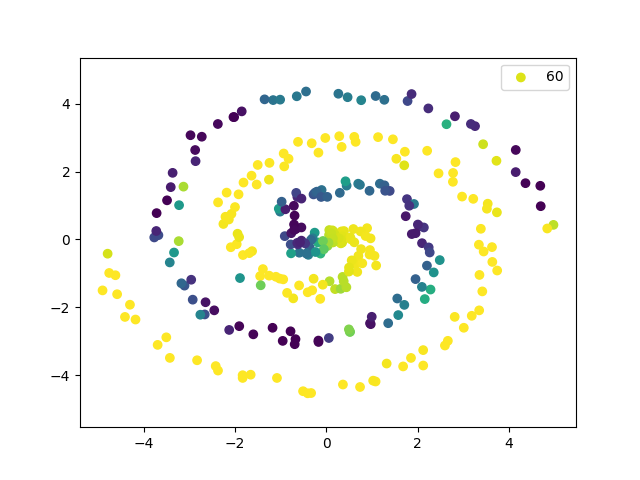

In [190]:
error_torch = 0
right = 0
predicted_labels = list()
for data, label in zip(test_data, labels_test):
    ptep = ((model(torch.tensor(data).float()) + 1) / 2).detach().clamp(0, 1).numpy()
    predicted_labels.append(ptep)
    ptep = 1 if ptep > .5 else -1
    right += ptep == label
    error_torch += abs(ptep - label)
print(right / len(labels_test), right, len(labels_test))
x_line = np.linspace(x_test.min(), x_test.max(), 20)
ax.clear()
pred_points = ax.scatter(x_test, y_test, c=predicted_labels, label=f"{error_torch}")
# pred_points.set_visible(False)

ax.set_ylim(y_test.min() - 1, y_test.max() + 1)
ax.legend()
plt.show(fig)